# Задача 6. Компьютерное зрение: задача сегментации

**Автор**: Степырев Даниил Федорович

**Группа**: 22.М05

## Задание

Выполненные пункты:
- [✔️] Сделать train/test split (или кросс-валидацию), зафиксировать все сиды чтобы более-менее воспроизводились результаты. Добавить метрику jaccard index. Переобучиться на одном батче (например 4 картинки), попробовать получить почти идеальное качество, посмотреть получилось или нет. Посчитать метрики для батча и для теста. Обучить на всем train, построить train/val кривые для loss и для jaccard index, подобрать оптимальное время обучения (количество шагов) для фиксированных параметров. Визуализировать topN самых плохих предсказаний.

- [✔️] Попробовать улучшить качество не меняя архитектуру: аугментации, гиперпараметры. Сделать test time аугментации через horizontal flip, посмотреть улучшается ли что-то.

- [✔️] Попробовать улучшить качество изменяя архитектуру.

## Датасет

В задаче используется датасет, указанный в условии. Доступен по ссылке: https://drive.google.com/file/d/11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe/view. В датасете есть набор изображений людей и набор масок.

## Подключение библиотек

Подключим используемые библиотеки:

In [7]:
import random

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

Зафиксируем сиды для воспроизведения результатов:

In [8]:
def set_seeds(initializer = 47):
    random.seed(initializer)
    torch.manual_seed(initializer)
    
set_seeds()

# Подготовка данных


Подключим Google Drive к Google Colab:

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Распакуем архив с датасетом, который находится в корне Google Drive:

In [10]:
!unzip gdrive/My\ Drive/dataset.zip

Archive:  gdrive/My Drive/dataset.zip
   creating: dataset/
   creating: dataset/masks/
  inflating: dataset/masks/1803262049-00000501.png  
  inflating: dataset/masks/1803280840-00000089.png  
  inflating: dataset/masks/1803242348-00000392.png  
  inflating: dataset/masks/1803251131-00000060.png  
  inflating: dataset/masks/1803240928-00000328.png  
  inflating: dataset/masks/1803260459-00000293.png  
  inflating: dataset/masks/1803271238-00000380.png  
  inflating: dataset/masks/1803280628-00000458.png  
  inflating: dataset/masks/1803280908-00000324.png  
  inflating: dataset/masks/1803260434-00000062.png  
  inflating: dataset/masks/1803241125-00000172.png  
  inflating: dataset/masks/1803191139-00000845.png  
  inflating: dataset/masks/1803260434-00000063.png  
  inflating: dataset/masks/1803251516-00000328.png  
  inflating: dataset/masks/1803191139-00000022.png  
  inflating: dataset/masks/1803262341-00000164.png  
  inflating: dataset/masks/1803241341-00000540.png  
  inflating

## Train/Test split

Считаем список путей изображений в папке **dataset/images/**:

In [11]:
from glob import glob

IMAGES_FOLDER_PATH = "./dataset/images"

imgs_list = glob(f"{IMAGES_FOLDER_PATH}/*")
print(f"Images list length: {len(imgs_list)}")

Images list length: 2000


Заведём класс для хранения изображений и их масок.

Название изображения маски похоже на название исходного изображения. Достаточно заменить папку с **images** на **masks**, а также сменить расширение файла с **.jpg** на **.png**. Тогда для получения изображения и его маски необходимо знать лишь путь до изображения.

In [12]:
from torch.utils.data import Dataset
import numpy as np
import torch
from torchvision import io
import cv2

class SelfieDataset(Dataset):
    def __init__(self, imgs_list, transform = None):
        self.imgs = imgs_list
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def get_mask_path(self, img_path):
        mask_path = img_path.split("/")
        mask_path[-2] = mask_path[-2].replace("images", "masks")
        mask_path[-1] = mask_path[-1][:-4] + ".png"
        mask_path = "/".join(mask_path)
        return mask_path

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = cv2.imread(img_path)[..., ::-1]
        img = cv2.resize(img[100:-100], (256, 256))
        img = torch.Tensor(img.copy()).permute(2, 0, 1) / 255.
        
        mask_path = self.get_mask_path(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)[..., -1]
        mask = cv2.resize(mask[100:-100], (256, 256)) > 100
        mask = torch.Tensor(mask.astype(int))[None, ...]

        if self.transform is not None:
            img = self.transform(img)
            mask = self.transform(mask)

        return img, mask

Заведём test и train выборки:

In [13]:
train_dataset = SelfieDataset(imgs_list[:-100])
test_dataset = SelfieDataset(imgs_list[-100:])

print(f"Train dataset length: {len(train_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

Train dataset length: 1900
Test dataset length: 100


Заведём функцию для отображения изображения из SelfieDataset:

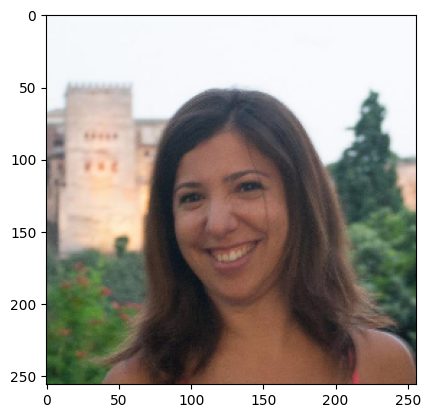

In [14]:
from torchvision.transforms import functional

def show_selfie(image, mask, is_mask_shown=True):
    if not is_mask_shown:
        plt.imshow(image.permute(1, 2, 0))
        return

    _, (ax_l, ax_r) = plt.subplots(ncols=2)
    ax_l.imshow(image.permute(1, 2, 0))
    ax_l.axis("off")
    ax_r.imshow(mask[0].detach().cpu().numpy())
    ax_r.axis("off")

image, mask = train_dataset[0]
show_selfie(image, mask, False)

## Jaccard Index метрика

Добавим функцию вычисления Jaccard Index метрики из библиотеки torchmetrics:

In [15]:
!pip install torchmetrics
from torchmetrics.classification import BinaryJaccardIndex

jaccard = BinaryJaccardIndex()

def calculate_jaccard_metric(y_pred, y_true):
    return jaccard(y_pred.cpu(), y_true.cpu())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 21.0 MB/s eta 0:00:00


## Реализация UNET

Реализуем UNET аналогично тому, как делали на практическом занятии.

Реализация Encoder:

In [16]:
from torch import nn

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True))

    def forward(self, x):
        return self.seq_block(x)

class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()

          self.layers = nn.ModuleList()
          for i in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections
    
    

Реализация Decoder:

In [17]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x

Реализация UNET:

In [18]:
class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down), # downscaled (so increase n maps 2x n_down times)
                               first_out_channels * (2 ** (n_down - 1)), # we have 2x channels here, because need to concat
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

## Переобучение на одном батче

Выполним переобучение на одном батче. Возьмём четыре картинки.

In [14]:
train_subset = torch.utils.data.Subset(train_dataset, range(4))
train_dataset_loader = torch.utils.data.DataLoader(train_subset, batch_size=4)

test_subset = torch.utils.data.Subset(test_dataset, range(4))
test_dataset_loader = torch.utils.data.DataLoader(test_subset, batch_size=4)

Реализуем функции обучения модели. Вычисленные значения loss, Jaccard Index Metric будем сохранять в словарь, чтобы по итогу обучения вернуть датафрейм. Датафрейм будет полезен для построения графиков.

In [71]:
from tqdm import tqdm

TRAIN_DATASET_NAME = "Train dataset"
TEST_DATASET_NAME = "Test dataset"
LOSS_PARAMETER = "Loss"
JACCARD_INDEX_PARAMETER = "Jaccard Index"
device = "cuda"

results_columns = ["Epoch number", "Dataset", "Parameter", "Result"]

net = UNET(3, 16, 1)
net = net.cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

def train(net, optimizer, loader):
    net.train()

    running_loss = 0.0
    running_metric = 0.0
    for x, y in tqdm(loader):
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        pred = net(x)
        
        loss = criterion(pred, y)
        metric = calculate_jaccard_metric(pred, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_metric += metric.item()

    return running_loss / len(loader), running_metric / len(loader)


def predict(net, loader):
    net.eval()

    running_loss = 0.0
    running_metric = 0.0
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.cuda()
            y = y.cuda()
            pred = net(x)
            running_loss += criterion(pred, y).item()
            running_metric += calculate_jaccard_metric(pred, y).item()

    return running_loss / len(loader), running_metric / len(loader)


def train_model(net, optimizer, train_dataset_loader, test_dataset_loader, epoch_number):
    results = []
    for epoch in range(epoch_number):
        loss_train, metric_train = train(net, optimizer, train_dataset_loader)
        loss_test, metric_test = predict(net, test_dataset_loader)
        results += [
            (epoch, TRAIN_DATASET_NAME, LOSS_PARAMETER, loss_train),
            (epoch, TRAIN_DATASET_NAME, JACCARD_INDEX_PARAMETER, metric_train),
            (epoch, TEST_DATASET_NAME, LOSS_PARAMETER, loss_test),
            (epoch, TEST_DATASET_NAME, JACCARD_INDEX_PARAMETER, metric_test),
        ]

    return pd.DataFrame(results, columns=results_columns)

Выполним переобучение на одном батче:

In [16]:
results = train_model(net, optimizer, train_dataset_loader, test_dataset_loader, 50)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Заведём функцию отображения результатов:

In [31]:
def show_result_plot(results, plot_title = ""):
    fig, (ax_1, ax_2) = plt.subplots(nrows=2, sharex=True, figsize=(15, 5))

    sns.lineplot(results[results["Parameter"] == LOSS_PARAMETER], x="Epoch number", y="Result", hue="Dataset",ax=ax_1)
    ax_1.set_title(LOSS_PARAMETER)

    sns.lineplot(results[results["Parameter"] == JACCARD_INDEX_PARAMETER], x="Epoch number", y="Result", hue="Dataset", ax=ax_2)
    ax_2.set_title(JACCARD_INDEX_PARAMETER)

    fig.suptitle(plot_title)
    fig.tight_layout()

Построим график обучения на одном батче:

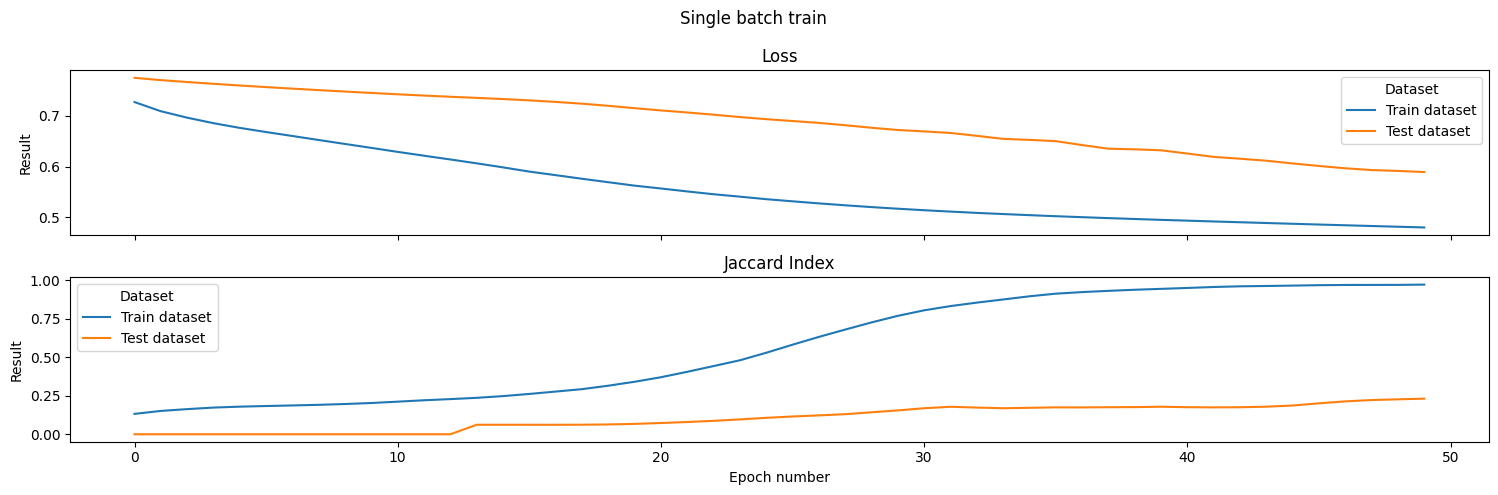

In [18]:
show_result_plot(results, "Single batch train")

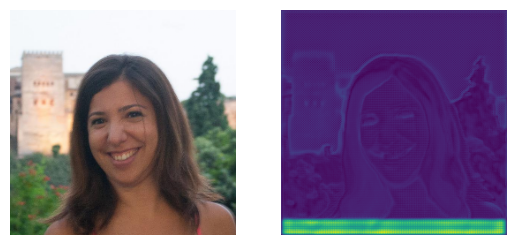

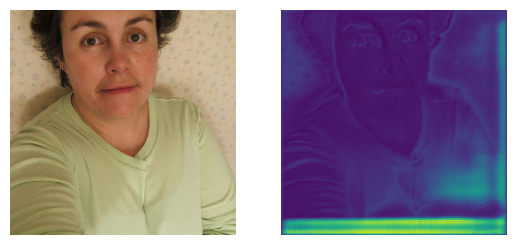

In [19]:
net.eval()

img, _ = train_dataset[0]
pred = net(img.cuda().unsqueeze(0))[0]
show_selfie(img, pred)

img, _ = test_dataset[0]
pred = net(img.cuda().unsqueeze(0))[0]
show_selfie(img, pred)

Видим, что результат обучающей выборки не сильно лучше результата тестовой. При возрастании числа шагов обучения снижается Loss и возрастает Jaccard Index.

# Обучение на всём Train

Выполним обучение на всей Train выборке. В качестве размера батча возьмём число 16.

In [59]:
batch_size = 16
epoch_number = 10 # Google Colab limits accounts for a big computations
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Обучим модель на всей выборке. Возьмём для теста 10 эпох. Результаты сохраним в results.csv.

In [23]:
from torch.utils.data.datapipes.datapipe import UNTRACABLE_DATAFRAME_PIPES
net = UNET(3, 16, 1)
net = net.cuda()
optimizer = torch.optim.Adam(net.parameters())
criterion = nn.BCEWithLogitsLoss()

train_model(net, optimizer, train_loader, test_loader, epoch_number).to_csv("results.csv")

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Построим график результатов обучения модели на всей выборке:

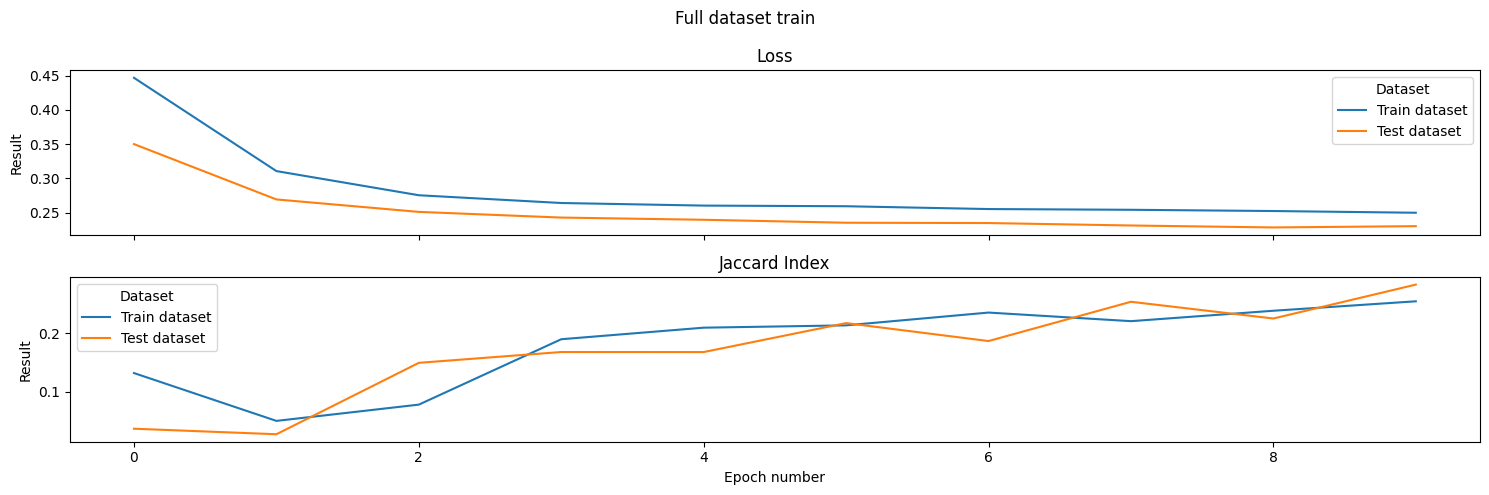

In [24]:
results = pd.read_csv("results.csv")
show_result_plot(results, "Full dataset train")

Из полученных результатов видим, что оптимальным временем обучения является количество шагов в диапазоне 8-10.

Реализуем функцию отбора самых плохих предсказаний:

In [34]:
def show_worst_predictions(net, number):
    predictions = []
    for i, data in tqdm(enumerate(test_loader, 0)):
        x = data[0]
        y = data[1]
        pred = net(x.cuda())
        metric = calculate_jaccard_metric(pred, y).item()
        predictions.append((metric, i))

    worst_predictions = sorted(predictions)[:number]
    for _, idx in worst_predictions:
        image, mask = test_dataset[idx]
        pred = net(image.cuda().unsqueeze(0))
        show_selfie(image, pred[0])

Найдем 5 худших результатов:

0it [00:00, ?it/s]

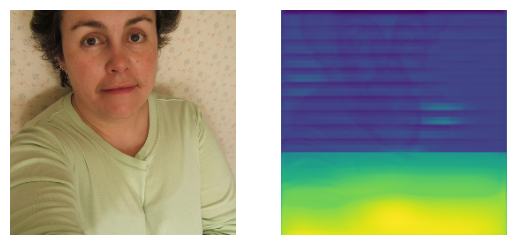

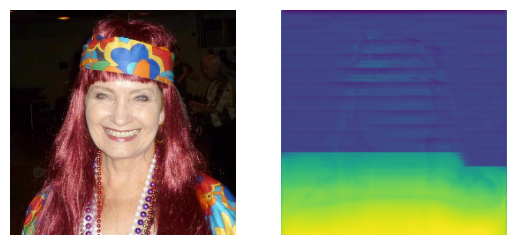

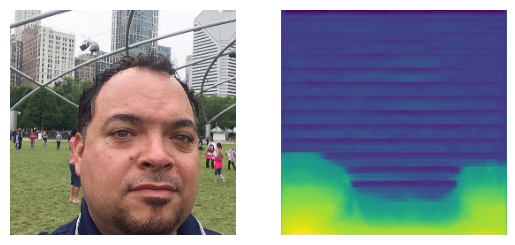

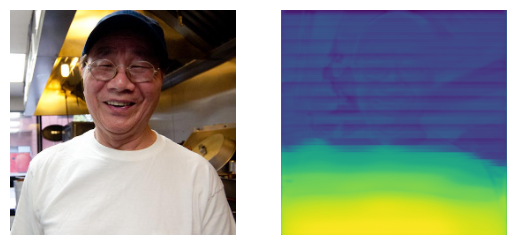

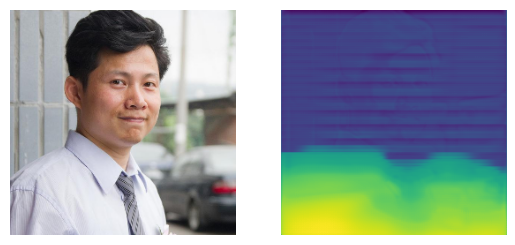

In [26]:
show_worst_predictions(net, 5)

# Аугментация

Попробуем улучшить качество предсказаний с помощью аугментации. Модифицируем существующие данные для увеличения выборки.

Применим отражение по горизонтали (horizontal flip) и изменение цвета изображения (color jitter):

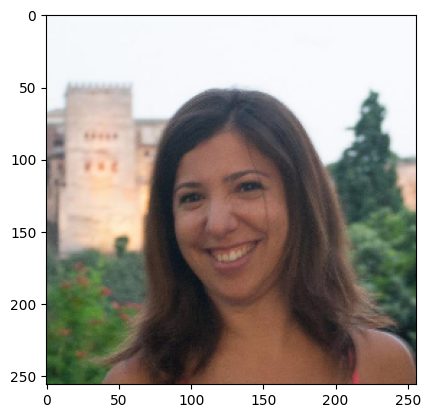

In [25]:
import copy
from torchvision import transforms

transformations = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(p=1),
    transforms.ColorJitter(brightness=.5, hue=.3)
)

train_dataset_augmented = copy.copy(train_dataset)
train_dataset_augmented.transform = transformations

img, mask = train_dataset[0]
show_selfie(img, mask, False)

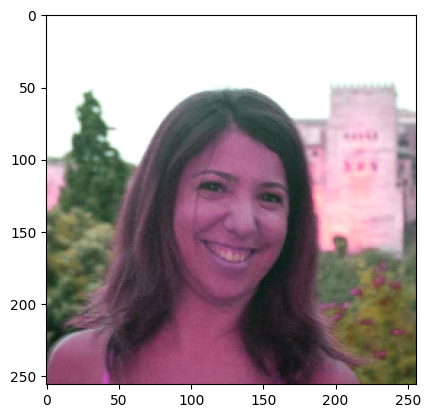

In [26]:
img, mask = train_dataset_augmented[0]
show_selfie(img, mask, False)

train_dataset_extended = torch.utils.data.ConcatDataset(
    [train_dataset, copy.copy(train_dataset)]
)

train_loader_extended = torch.utils.data.DataLoader(train_dataset_extended, batch_size=batch_size)

Обучим модель на расширенных данных.

In [29]:
train_model(net, optimizer, train_loader_extended, test_loader, epoch_number).to_csv("results-augmented.csv")

  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Сразу можно заметить, что время обучения возросло почти в два раза. Построим график с результатами:

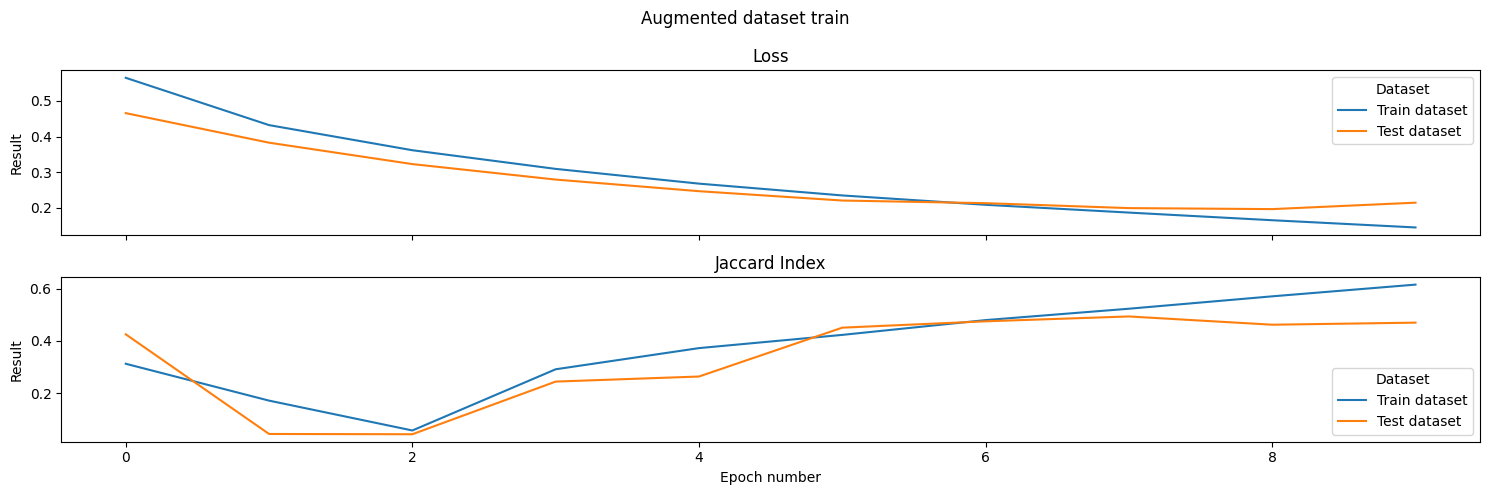

In [32]:
results = pd.read_csv("results-augmented.csv")
show_result_plot(results, "Augmented dataset train")

Видим на графике, что Loss для тестовой выборки уменьшился, а Jaccard Index увеличился.

Посмотрим на 5 худших предсказаний:

0it [00:00, ?it/s]

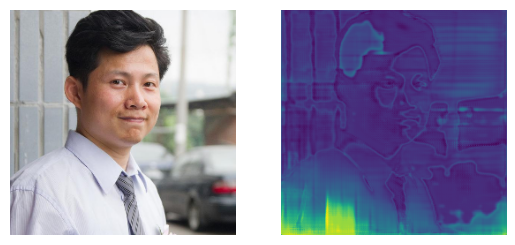

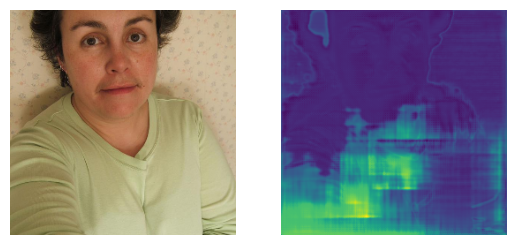

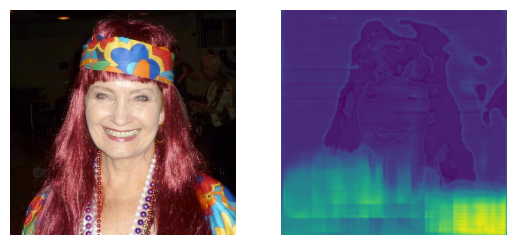

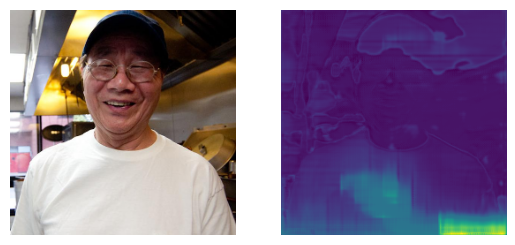

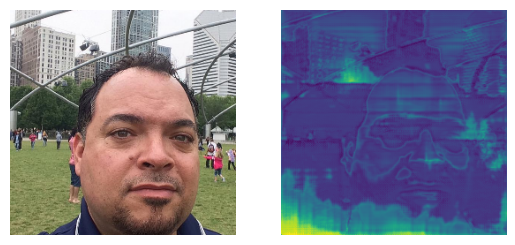

In [35]:
show_worst_predictions(net, 5)

Также можно заметить, что на худших предсказаниях при аугментированном датасете можно раглядеть контур человека. Результат далек от идеала, но все равно визуально лучше, чем до аугментации.

# Гиперпараметры

Попробуем улучшить качество предсказаний с помощью подбора гиперпараметров. Попробуем разные значения padding:

In [36]:
def train_and_save_to_csv(padding, train_loader, test_loader):
    net = UNET(3, padding, 1).cuda()
    optimizer = torch.optim.Adam(net.parameters())

    train_model(net, optimizer, train_loader, test_loader, epoch_number).to_csv(f"results-hyperparam-{padding}.csv")

padding_parameters = [8, 16, 32]
for padding in padding_parameters:
    print(f"Training net with {padding} padding")
    train_and_save_to_csv(padding, train_loader, test_loader)

Training net with 8 padding


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training net with 16 padding


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training net with 32 padding


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Посмотрим график результата для padding = 8:

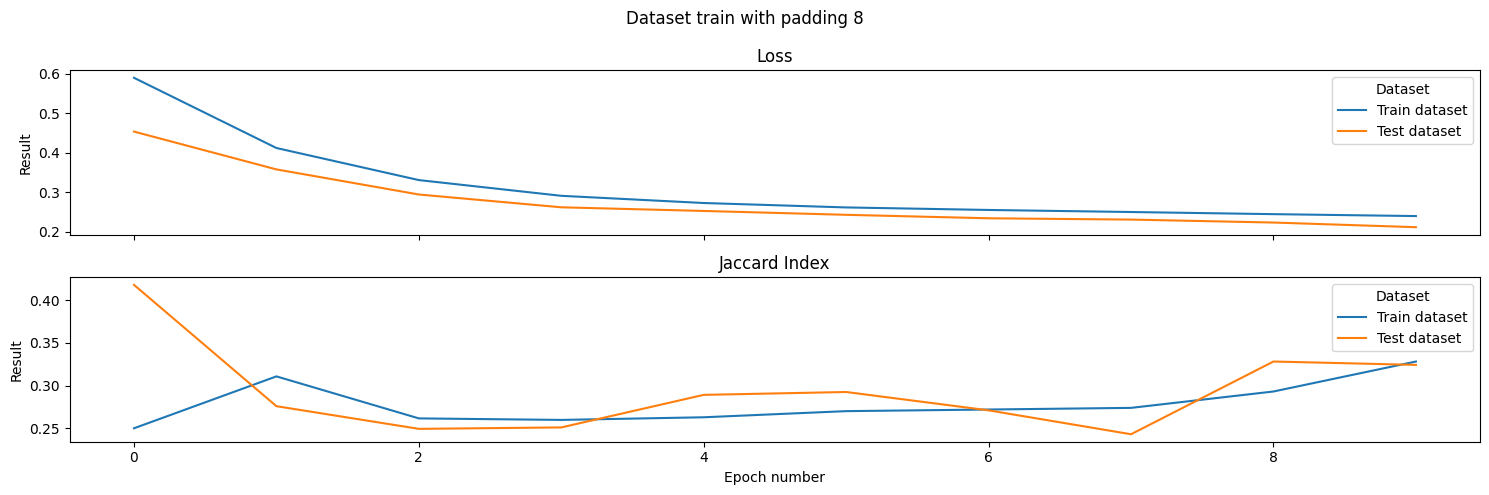

In [37]:
results = pd.read_csv("results-hyperparam-8.csv")
show_result_plot(results, "Dataset train with padding 8")

Посмотрим график результата для padding = 16:

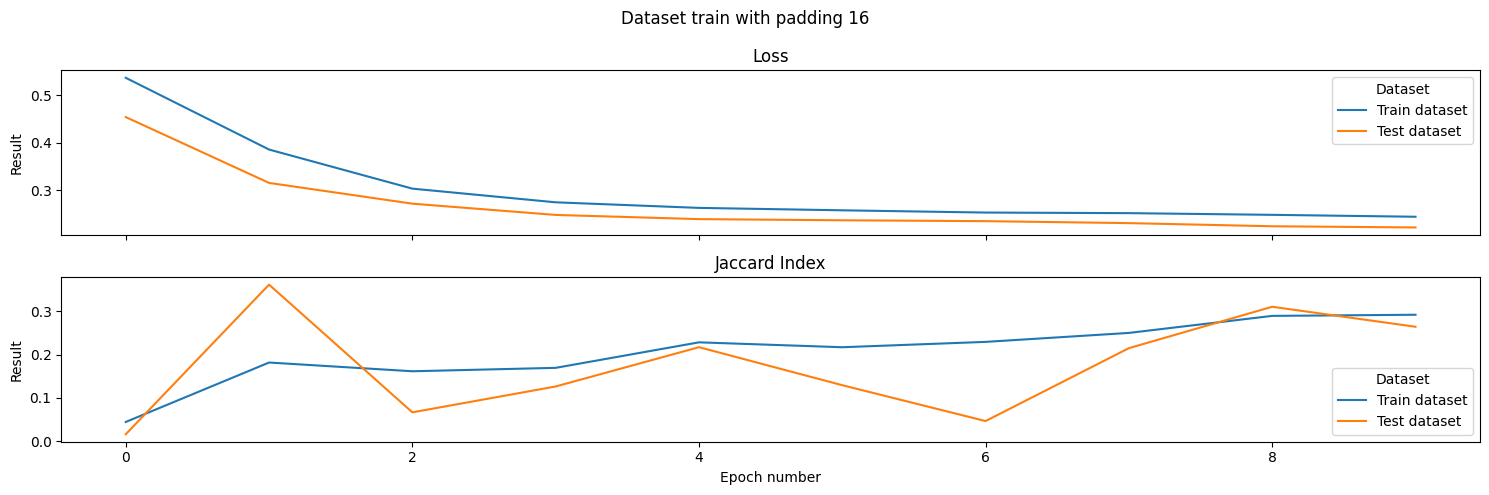

In [38]:
results = pd.read_csv("results-hyperparam-16.csv")
show_result_plot(results, "Dataset train with padding 16")

Посмотрим график результата для padding = 32:

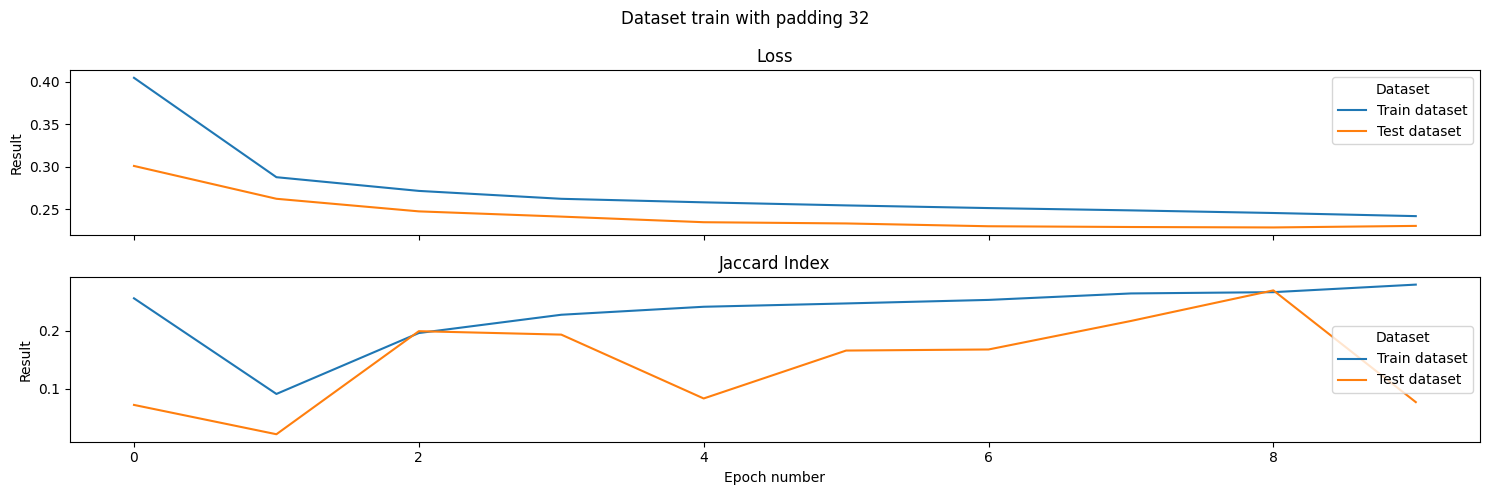

In [39]:
results = pd.read_csv("results-hyperparam-32.csv")
show_result_plot(results, "Dataset train with padding 32")

Если смотреть на значения, то лучше всего отработала модель с параметром padding = 8. У этой модели на последнем шаге получилось наименьшее значение Loss и наибольшее значение Jaccard Index.

Результат модели с параметром padding = 16 оказался чуть хуже. На одну сотую больше значение Loss и меньше значение Jaccard Index. Результат модели с параметром padding = 32 оказался хуже остальных.

Модель с параметром padding = 8 оказалось самой быстробучаемой. Самая медленная скорость обучения у модели с padding = 32.

# Test Time аугментации

Реализуем Test Time аугментацию, использую horizontal flip:

In [40]:
class SegmentationTTAWrapper(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net


    def horizontal_flip(self, image):
        # Use p = 1 to flip image.
        transformation = transforms.RandomHorizontalFlip(p=1)
        return transformation(image)
    

    def forward(self, image):
        flipped_image = self.horizontal_flip(image)
        concatenated_image = torch.cat([image, flipped_image])
        prediction = self.net(concatenated_image)

        result, augmented_result = prediction.chunk(2)
        flipped_augmented_result = self.horizontal_flip(augmented_result)

        return torch.mean(torch.stack([result, flipped_augmented_result]), dim=0)

Обучим TTA модель:

In [41]:
net = UNET(3, 8, 1).cuda()
tta_net = SegmentationTTAWrapper(net).cuda()

optimizer = torch.optim.Adam(tta_net.parameters())
train_model(tta_net, optimizer, train_loader, test_loader, epoch_number).to_csv(f"results-tta.csv")

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Посмотрим график результата для TTA:

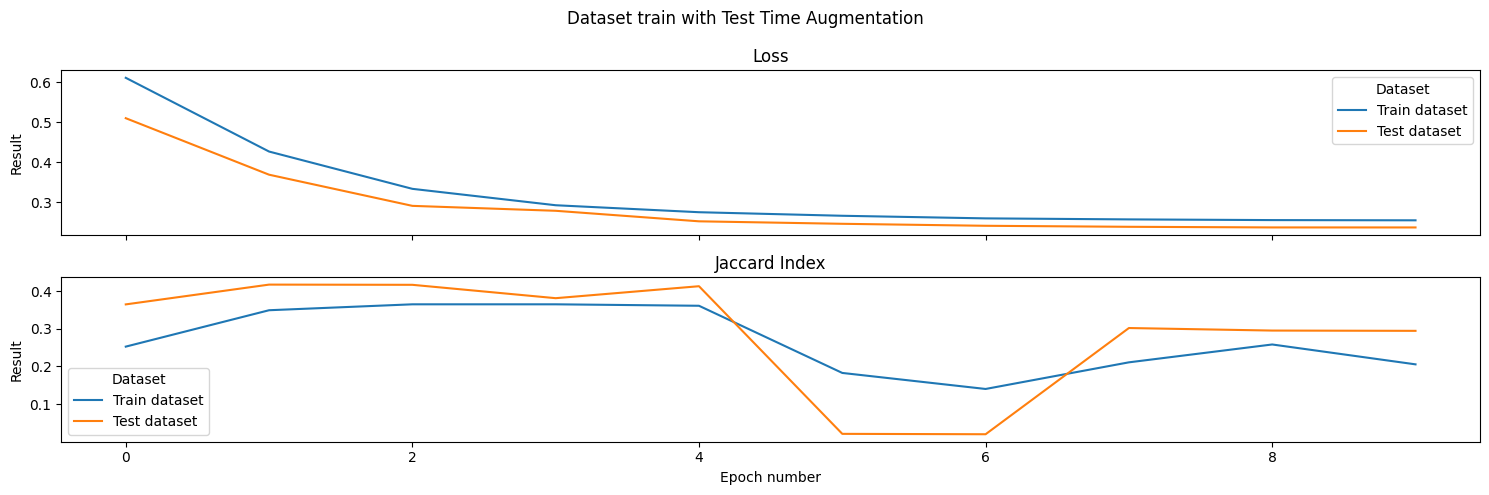

In [42]:
results = pd.read_csv("results-tta.csv")
show_result_plot(results, "Dataset train with Test Time Augmentation")

Из графика и результатов видим, что по сравнению с обычной UNET моделью значение Loss стало меньше, а Jaccard Index больше.

# Изменение архитектуры

Попробуем улучшить качество, изменив архитектуру решения. Возьмём архитектуру, описанную в решении Aman Arora: https://amaarora.github.io/posts/2020-09-13-unet.html.

In [89]:
import torchvision

class NBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class NEncoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([NBlock(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class NDecoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([NBlock(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class NUNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = NEncoder(enc_chs)
        self.decoder     = NDecoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.out_sz      = out_sz

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = torch.nn.functional.interpolate(out, self.out_sz)
        return out

In [90]:
net = NUNet(retain_dim=True, out_sz=(256,256)).cuda()
optimizer = torch.optim.Adam(net.parameters())

train_model(net, optimizer, train_loader_extended, test_loader, epoch_number).to_csv("results-architecture.csv")

100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


Построим график результатов обучения с новой архитектурой (с аугментацией):

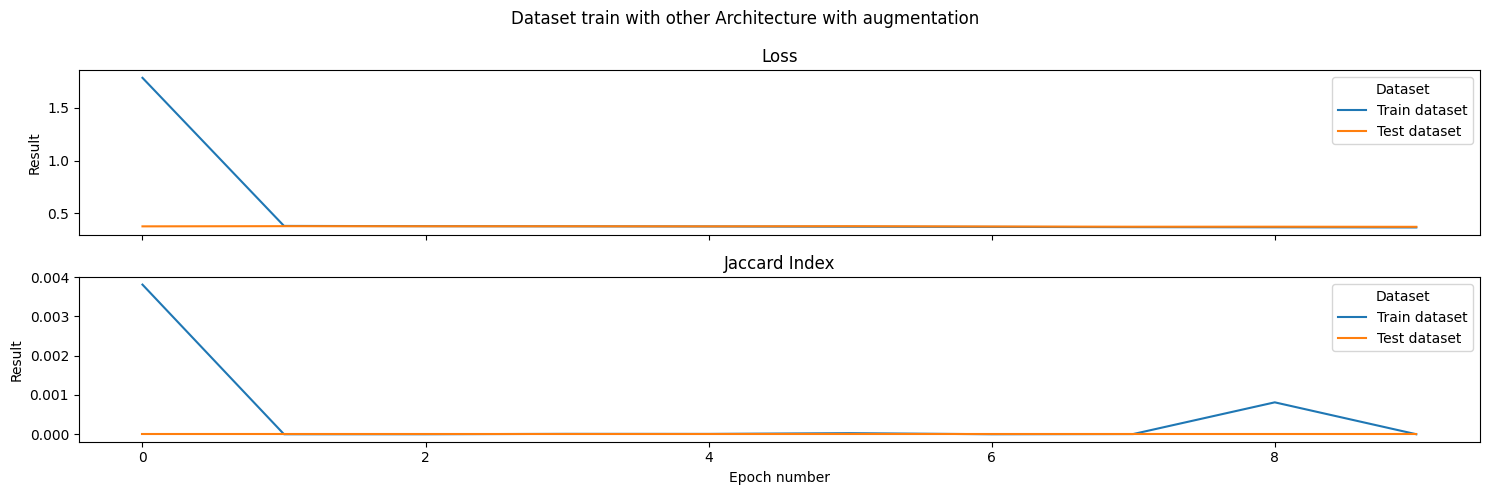

In [92]:
results = pd.read_csv("results-architecture.csv")
show_result_plot(results, "Dataset train with other Architecture with augmentation")

Построим график результатов обучения с новой архитектурой (без аугментации):

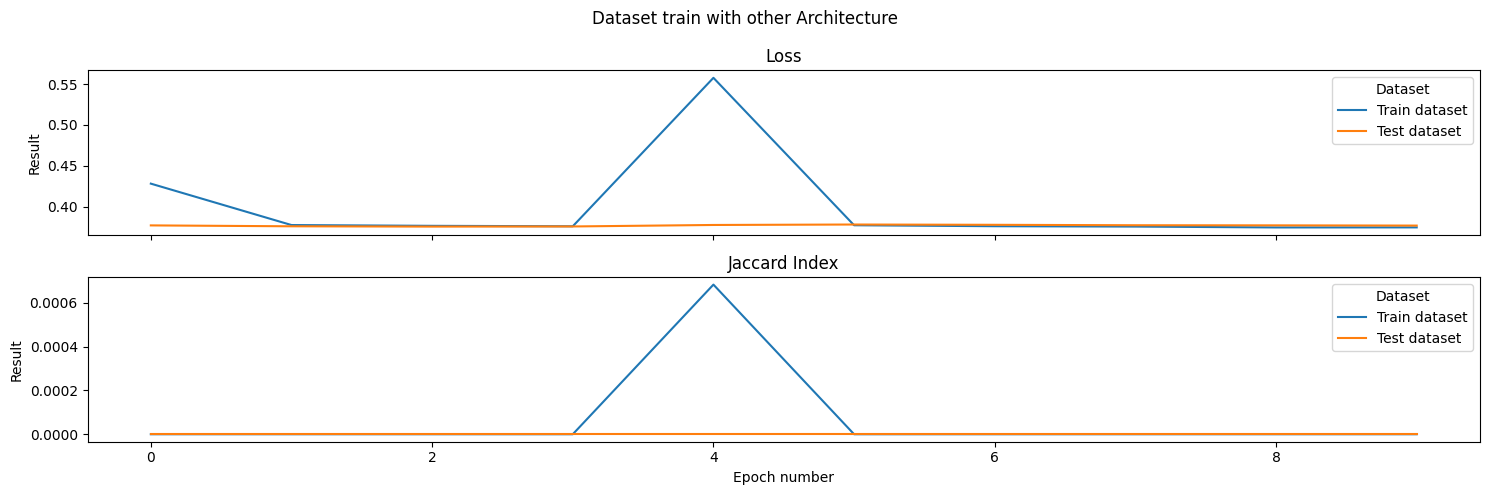

In [93]:
results = pd.read_csv("result-architecture.csv")
show_result_plot(results, "Dataset train with other Architecture")

Видим, что результаты получились хуже, чем при исходной архитектуре. Без аугментации результат получился чуть лучше, но все равно хуже исходной архитектуры.

# Выводы

- Переобучение на одном батче не дало идеального качества:
  + На обучающем датасете получили хороший результат, но предсказание на тестовом датасете не было идеальным: получили высокое значение Loss и среднее значение Jaccard Index.
- Оптимальное число шагов обучения получилось равным 10
  + Большее число шагов не использовалось из-за ограничений Google Colab; один аккаунт уже получил ограничения на обработку.
- Аугментация позволяет улучшить качество предсказаний исходной модели.
  + Использование аугментации значительно увеличивает скорость обучения модели (примерно в два раза).
- Подбор гиперпараметров позволяят улучшить качество предсказаний исходной модели. На тестовых данных лучшим гиперпараметром оказался padding = 8.
  + Подбор гиперпараметров увеличивает время обучения модели.
- Использование Test Time аугментации позволяет улучшить качество предсказаний исходной модели.
  + Использование Test Time аугментации увеличивает время обучения модели.
- Изменение архитектуры влияет на качество предсказаний.
  + В качестве примера была использована реализация из открытых источников;
  + Качество предсказаний реализации из открытых источников оказалось заметно хуже исходной архитектуры;
  + Качество предсказаний реализации из открытых источников оказалось лучше без использования аугментации.

